## Homework 06-random-forest

### Obtengo datos

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
 
# this line is needed to display the plots in notebooks
%matplotlib inline

In [2]:
data ='https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

In [3]:
!wget $data

--2025-11-03 21:50:59--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.02s   

2025-11-03 21:51:00 (36.8 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [4]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [5]:
df.head(3)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341


In [7]:
df.shape

(9704, 11)

### Preparo datos 

In [7]:
df_0 = df

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9222 non-null   float64
 2   horsepower           8996 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         8774 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9202 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


In [9]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [10]:
df = df.fillna(0)

In [11]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

## Dividir el dataset

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_test), len(df_val)

(5822, 1941, 1941)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [16]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [17]:
dicts = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

### Question 1

In [18]:
from sklearn.tree import DecisionTreeRegressor

In [20]:
dr = DecisionTreeRegressor(max_depth=1)
dr.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [22]:
from sklearn.tree import export_text
print(export_text(dr, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



Rta1: vehicle_weight

### Question 2

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
rf = RandomForestRegressor(n_estimators=10, 
                            random_state=1,
                            n_jobs=-1
                           )
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [31]:
y_pred = rf.predict(X_val)

In [32]:
y_pred

array([18.62889858, 15.29598647, 18.22879442, ..., 14.80283652,
       13.49358341, 15.99288211], shape=(1941,))

In [33]:
## Defino RMSE

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [34]:
rmse(y_val, y_pred)

np.float64(0.4599777557336148)

Rta2: 0.45

### Question 3

In [39]:
scores = []
 
for n in range(10, 301, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
 
    y_pred = rf.predict(X_val)
    RMSE = rmse(y_val, y_pred)
     
    scores.append((n, RMSE))
 
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'RMSE'])
df_scores

,n_estimators,RMSE
0,10,0.459978
1,20,0.453659
2,30,0.450743
3,40,0.448007
4,50,0.446151
5,60,0.445266
6,70,0.444610
7,80,0.444893
8,90,0.444724
9,100,0.444318


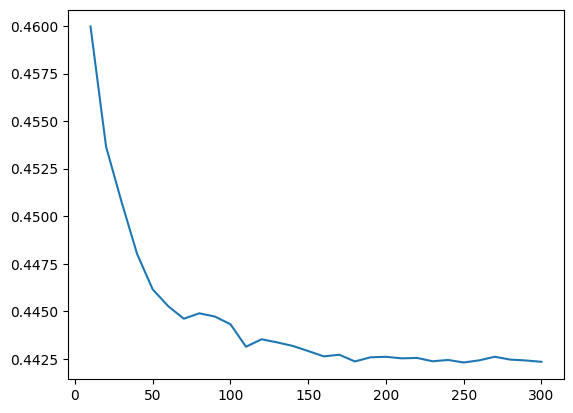

In [40]:
plt.plot(df_scores.n_estimators, df_scores.RMSE)

Rta 3: 200

### Question 4

In [41]:
scores = []
 
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
 
        y_pred = rf.predict(X_val)
        RMSE = rmse(y_val, y_pred)
 
        scores.append((d, n, RMSE))
 
columns = ['max_depth', 'n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,RMSE
0,10,10,0.451895
1,10,20,0.448719
2,10,30,0.446225
3,10,40,0.443877
4,10,50,0.442682


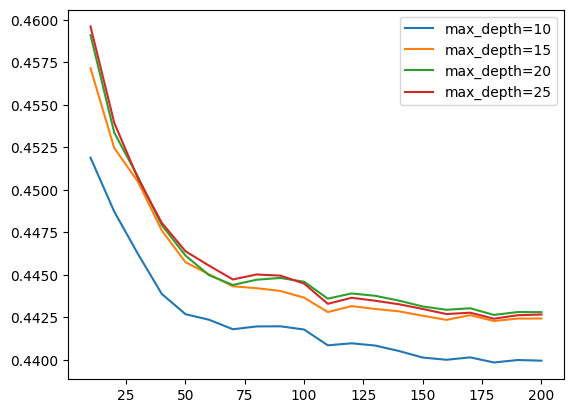

In [42]:
# Let's plot it
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
     
    plt.plot(df_subset.n_estimators, df_subset.RMSE,
             label='max_depth=%d' % d)
 
plt.legend()

Rta 4: 10

### Question 5